In [3]:
!pip install yfinance arch pandas numpy matplotlib

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from arch import arch_model

plt.style.use("default")

TICKER = "^GSPC"
START_DATE = "2010-01-01"
END_DATE = "2024-12-31"

TRADING_DAYS = 252
ROLLING_WINDOW = 21
TARGET_VOL_ANNUAL = 0.10  # 10%
MAX_LEVERAGE = 2.0
MIN_LEVERAGE = 0.0

In [12]:
import os
os.makedirs("plots", exist_ok=True)

In [5]:
data = yf.download(TICKER, start=START_DATE, end=END_DATE, auto_adjust=True)

print("Colonne di data:", data.columns)

prices = data["Close"]

if isinstance(prices, pd.DataFrame):
    prices = prices.iloc[:, 0]

prices = pd.Series(prices.squeeze(), index=data.index, name="price").dropna()

log_ret = np.log(prices / prices.shift(1)).dropna()
log_ret.name = "log_return"

df = pd.DataFrame({"price": prices, "log_return": log_ret}).dropna()

df.head()

[*********************100%***********************]  1 of 1 completed

Colonne di data: MultiIndex([( 'Close', '^GSPC'),
            (  'High', '^GSPC'),
            (   'Low', '^GSPC'),
            (  'Open', '^GSPC'),
            ('Volume', '^GSPC')],
           names=['Price', 'Ticker'])


,price,log_return
Date,,
2010-01-05,1136.520020,0.003111
2010-01-06,1137.140015,0.000545
2010-01-07,1141.689941,0.003993
2010-01-08,1144.979980,0.002878
2010-01-11,1146.979980,0.001745


In [6]:
rv_daily = df["log_return"].rolling(ROLLING_WINDOW).std()
rv_annual = rv_daily * np.sqrt(TRADING_DAYS)

df["realized_vol"] = rv_annual
df.dropna(inplace=True)
df.head()

,price,log_return,realized_vol
Date,,,
2010-02-03,1097.280029,-0.005489,0.162803
2010-02-04,1063.109985,-0.031636,0.192181
2010-02-05,1066.189941,0.002893,0.192925
2010-02-08,1056.739990,-0.008903,0.192149
2010-02-09,1070.520020,0.012956,0.199514


In [7]:
ret_for_garch = df["log_return"] * 100

garch = arch_model(ret_for_garch, vol="Garch", p=1, q=1, mean="Constant", dist="normal")

garch_res = garch.fit(disp="off")
print(garch_res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4815.24
Distribution:                  Normal   AIC:                           9638.48
Method:            Maximum Likelihood   BIC:                           9663.40
                                        No. Observations:                 3752
Date:                Wed, Nov 26 2025   Df Residuals:                     3751
Time:                        11:23:39   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0793  1.233e-02      6.431  1.264e-10 [5.513e-0

In [8]:
sigma_daily_pct = garch_res.conditional_volatility

sigma_daily = sigma_daily_pct / 100.0
sigma_annual = sigma_daily * np.sqrt(TRADING_DAYS)

garch_vol = pd.Series(sigma_annual, index=df.index, name="garch_vol")

df["garch_vol"] = garch_vol

comp = df[["realized_vol", "garch_vol"]].dropna()

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(comp["realized_vol"], comp["garch_vol"])
mae = mean_absolute_error(comp["realized_vol"], comp["garch_vol"])

print("MSE GARCH vs Realized:", mse)
print("MAE GARCH vs Realized:", mae)

comp.tail()

MSE GARCH vs Realized: 0.001504879241902499
MAE GARCH vs Realized: 0.026291157544655504


,realized_vol,garch_vol
Date,,
2024-12-23,0.132300,0.190816
2024-12-24,0.137112,0.178717
2024-12-26,0.136852,0.175771
2024-12-27,0.140977,0.160756
2024-12-30,0.145089,0.166006


In [9]:
errors = comp["garch_vol"] - comp["realized_vol"]
mse_manual = np.mean(errors**2)
mae_manual = np.mean(np.abs(errors))

print("MSE (manual):", mse_manual)
print("MAE (manual):", mae_manual)

MSE (manual): 0.001504879241902499
MAE (manual): 0.026291157544655504


In [10]:
forecast_vol = df["garch_vol"].shift(1)

weight = TARGET_VOL_ANNUAL / forecast_vol
weight = weight.clip(lower=MIN_LEVERAGE, upper=MAX_LEVERAGE)

df["weight_vol_target"] = weight

df["ret_buy_hold"] = df["log_return"]

df["ret_vol_target"] = df["weight_vol_target"] * df["log_return"]

df.dropna(inplace=True)

df["equity_buy_hold"] = (1 + df["ret_buy_hold"]).cumprod()
df["equity_vol_target"] = (1 + df["ret_vol_target"]).cumprod()

df[["equity_buy_hold", "equity_vol_target"]].tail()

,equity_buy_hold,equity_vol_target
Date,,
2024-12-23,4.352269,2.750007
2024-12-24,4.400067,2.765835
2024-12-26,4.398282,2.765207
2024-12-27,4.349384,2.747717
2024-12-30,4.302587,2.729327


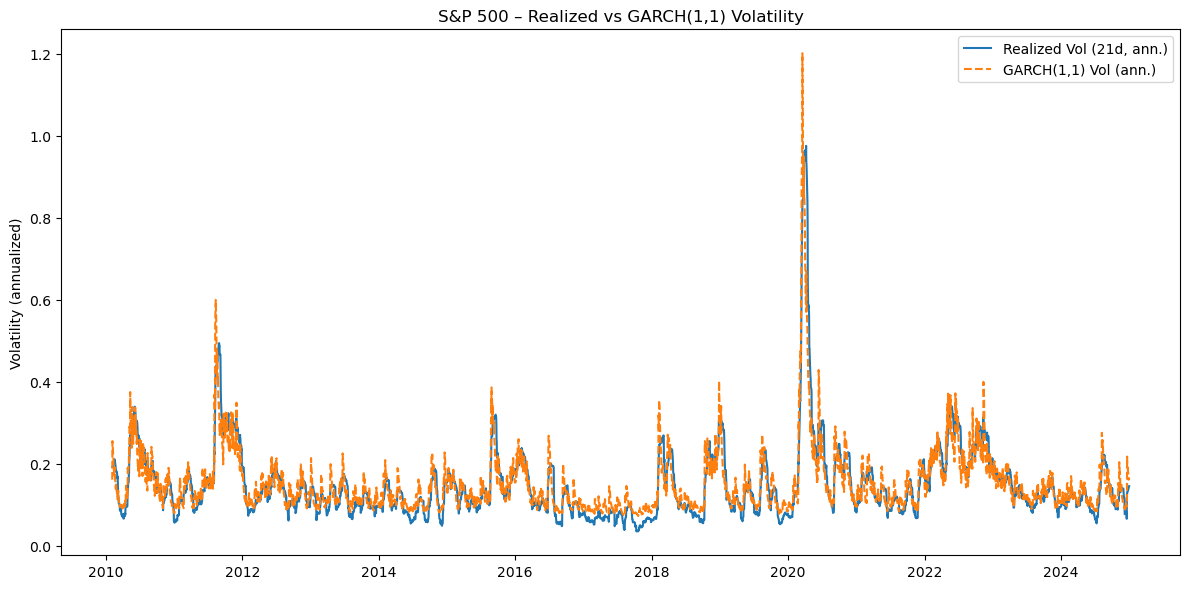

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.index, df["realized_vol"], label="Realized Vol (21d, ann.)")
ax.plot(df.index, df["garch_vol"], label="GARCH(1,1) Vol (ann.)", linestyle="--")

ax.set_title("S&P 500 – Realized vs GARCH(1,1) Volatility")
ax.set_ylabel("Volatility (annualized)")
ax.legend()
plt.tight_layout()
plt.savefig("plots/volatility_comparison.png", dpi=300)

plt.show()

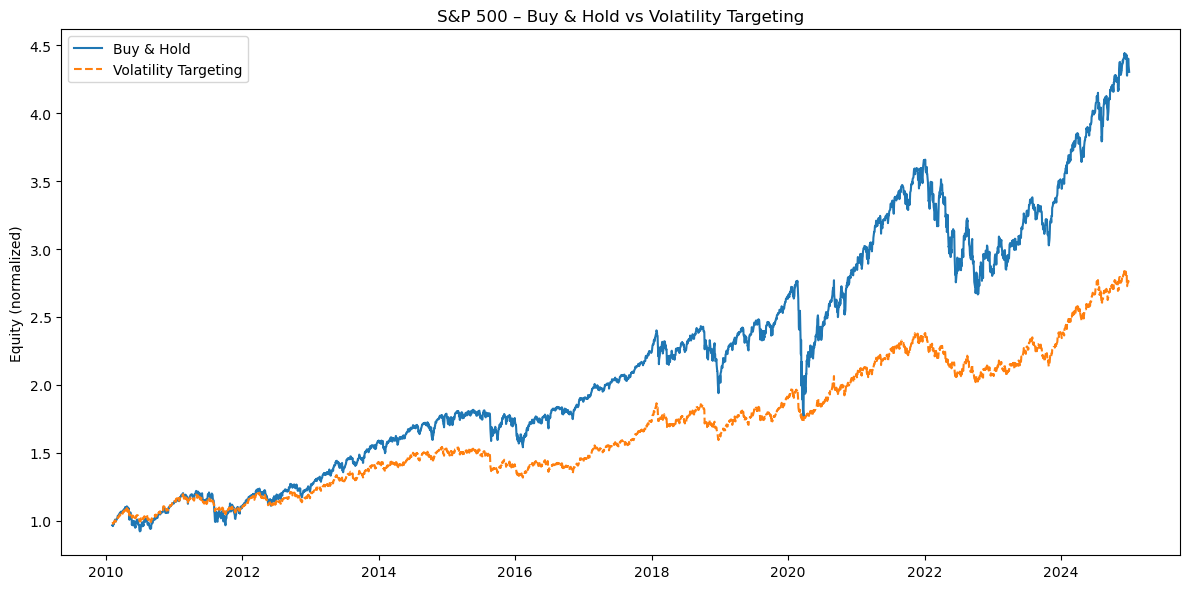

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(df.index, df["equity_buy_hold"], label="Buy & Hold")
ax.plot(df.index, df["equity_vol_target"], label="Volatility Targeting", linestyle="--")

ax.set_title("S&P 500 – Buy & Hold vs Volatility Targeting")
ax.set_ylabel("Equity (normalized)")
ax.legend()
plt.tight_layout()
plt.savefig("plots/equity_curves.png", dpi=300)

plt.show()

In [15]:
def sharpe_ratio(returns, trading_days=TRADING_DAYS):
    mean_daily = returns.mean()
    std_daily = returns.std()
    return (mean_daily / std_daily) * np.sqrt(trading_days)

def max_drawdown(equity_curve):
    rolling_max = equity_curve.cummax()
    drawdown = equity_curve / rolling_max - 1.0
    return drawdown.min()

shr_bh = sharpe_ratio(df["ret_buy_hold"])
shr_vt = sharpe_ratio(df["ret_vol_target"])

mdd_bh = max_drawdown(df["equity_buy_hold"])
mdd_vt = max_drawdown(df["equity_vol_target"])

print("Buy & Hold Sharpe:", shr_bh)
print("Vol-Target Sharpe:", shr_vt)
print("Buy & Hold Max Drawdown:", mdd_bh)
print("Vol-Target Max Drawdown:", mdd_vt)

Buy & Hold Sharpe: 0.6539548158457692
Vol-Target Sharpe: 0.718762064658121
Buy & Hold Max Drawdown: -0.3610263975238489
Vol-Target Max Drawdown: -0.15162186054261162
